<a href="https://colab.research.google.com/github/JahnaviRamagiri/Brain-Tumor-Detection-Classification/blob/master/S15/Code_Implementation/S15_FinalModular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -U git+https://github.com/albu/albumentations

In [ ]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Import Libraries

In [ ]:
from torch.utils.data import Dataset, random_split
import math
from PIL import Image
import cv2
import numpy as np
import torch
import os
from tqdm import notebook
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt

#Import Custom Packages

In [ ]:
from Custom_Dataset import *
from Data_Transform import *
import Test
import Train
import Train_model
from UnetModel import *
import Results

In [ ]:
# os.chdir("/content/drive/My Drive/Utils/S15_Dataset/")

### Albumentations

In [ ]:
class Albumentation:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms=[]):
    self.transforms = A.Compose(transforms)

  def __call__(self, img):
    img = np.array(img)
    return self.transforms(image=img)['image']

### Transforms

In [ ]:
input_img_means = (0.5558092594146729, 0.5201340913772583, 0.463156521320343, 0.5455222129821777, 0.5086212158203125, 0.45718181133270264)
input_img_std = (0.2149990200996399, 0.21596555411815643, 0.23049025237560272, 0.22610004246234894, 0.2249932438135147, 0.23590309917926788)
mask_means = (0.05790501832962036)
mask_std =  (0.22068527340888977)
depth_means = (0.40361160039901733)
depth_std = (0.19922664761543274)

In [ ]:
input_transforms_data = [A.Resize(64,64), A.Normalize(mean=input_img_means, std=input_img_std), AP.ToTensor() ]
mask_transform_data = [A.Resize(64,64), A.Normalize(mean=mask_means, std=mask_std), A.Transpose(always_apply=True), AP.ToTensor() ]
depth_transform_data = [A.Resize(64,64), A.Normalize(mean=depth_means, std=depth_std), A.Transpose(always_apply=True), AP.ToTensor() ]

input_transforms = Albumentation(transforms = input_transforms_data)
mask_transforms = Albumentation(transforms = mask_transform_data)
depth_transforms = Albumentation(transforms = depth_transform_data)

transforms = {
    "input" : input_transforms,
    "mask": mask_transforms,
    "depth" : depth_transforms
}



### Get Train, Test Dataset

In [ ]:
def get_train_test_data(split = 70, train_transforms = None, test_transforms = None, start_no=1, end_no = 101):
  custom_data_set = CustomDataSet(start_no, end_no)
  train_len = len(custom_data_set) * split//100
  test_len = len(custom_data_set) - train_len 
  train_set, val_set = random_split(custom_data_set, [train_len, test_len])
  train_dataset = CustomTrainDataSet(train_set, transform=train_transforms)
  test_dataset = CustomTrainDataSet(val_set, transform=test_transforms)
  return train_dataset, test_dataset

In [ ]:

train_dataset, test_dataset = get_train_test_data(start_no = 20, end_no = 23, train_transforms = transforms, test_transforms = transforms)
print(len(train_dataset))
print(len(test_dataset))

start
start
start
end
8400
3600


In [ ]:
input_img, fg_bg_masks, fg_bg_depth = train_dataset[0]

In [ ]:
input_img.shape

torch.Size([6, 64, 64])

In [ ]:
fg_bg_masks

tensor([[-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        ...,
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624],
        [-0.2624, -0.2624, -0.2624,  ..., -0.2624, -0.2624, -0.2624]])

In [ ]:
fg_bg_depth

tensor([[ 0.6708,  0.6118,  0.6314,  ...,  0.1197,  0.0606, -0.1559],
        [ 0.7889,  0.7495,  0.7692,  ...,  0.1787,  0.1590,  0.0212],
        [ 0.8480,  0.8086,  0.8086,  ...,  0.1590,  0.1393,  0.0409],
        ...,
        [-0.6874, -0.9236, -0.3921,  ..., -1.0220, -1.0220, -0.9826],
        [-0.6086, -0.8055, -0.4709,  ..., -1.0023, -1.0023, -0.9039],
        [-0.4512, -0.6283, -0.5890,  ..., -0.9826, -1.0023, -0.7268]])

In [ ]:
img1,mask,depth = test_dataset[0]

In [ ]:
img1.shape

torch.Size([6, 64, 64])

In [ ]:
mask.shape

torch.Size([64, 64])

In [ ]:
depth.shape

torch.Size([64, 64])

### Get Data Loader

In [ ]:
def get_data_loader(train_set,test_set,seed=1,batch_size=8,num_workers=4,pin_memory=True):
  SEED = 1
  cuda = torch.cuda.is_available()
  torch.manual_seed(SEED)
  if cuda:
    torch.cuda.manual_seed(SEED)
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)
  train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)
  test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)
  return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_data_loader(train_dataset, test_dataset)

### Model Summary

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(n_channels = 6,n_classes = 1).to(device)
summary(model, input_size=(6, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           1,760
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
        DoubleConv-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,928
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

### Model Training

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR,StepLR
lr=0.01
model = UNet(n_channels = 6,n_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2, verbose=False)


mask_criterion = nn.BCEWithLogitsLoss()
depth_criterion =nn.BCEWithLogitsLoss()

In [ ]:
import torch.nn as nn

train_model(model,device,train_loader,test_loader,optimizer,mask_criterion,depth_criterion,10,scheduler,batch_scheduler=False,best_loss = 999)

EPOCH: 1 LR: 0.01


total_lenght 1050

avaerage_loss 678503.7411242723
train loss
[(0.6570121588593437, 0.5738336300282251)]




Test set: Average loss: 0.8793
******************************
EPOCH: 2 LR: 0.01


total_lenght 1050

avaerage_loss 673437.0817065239
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425)]




Test set: Average loss: 0.8758
******************************
EPOCH: 3 LR: 0.01


total_lenght 1050

avaerage_loss 672385.1028040051
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746)]




Test set: Average loss: 0.8838
******************************
EPOCH: 4 LR: 0.01


total_lenght 1050

avaerage_loss 671976.2952893972
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535)]




Test set: Average loss: 0.8584
******************************
EPOCH: 5 LR: 0.01


total_lenght 1050

avaerage_loss 671546.9511419535
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529)]




Test set: Average loss: 0.8665
******************************
EPOCH: 6 LR: 0.01


total_lenght 1050

avaerage_loss 671261.9879901409
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529), (0.6537806944052378, 0.5639281273455847)]




Test set: Average loss: 0.8747
******************************
EPOCH: 7 LR: 0.01


total_lenght 1050

avaerage_loss 670922.0861122012
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529), (0.6537806944052378, 0.5639281273455847), (0.6536736080192385, 0.563418611685435)]




Test set: Average loss: 0.8599
******************************
EPOCH: 8 LR: 0.001


total_lenght 1050

avaerage_loss 669809.5790281892
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529), (0.6537806944052378, 0.5639281273455847), (0.6536736080192385, 0.563418611685435), (0.6534250522227515, 0.5616490140415373)]




Test set: Average loss: 0.8789
******************************
EPOCH: 9 LR: 0.001


total_lenght 1050

avaerage_loss 669539.4788146019
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529), (0.6537806944052378, 0.5639281273455847), (0.6536736080192385, 0.563418611685435), (0.6534250522227515, 0.5616490140415373), (0.653369053318387, 0.5612150352341788)]




Test set: Average loss: 0.8773
******************************
EPOCH: 10 LR: 0.001


total_lenght 1050

avaerage_loss 669355.3548574448
train loss
[(0.6570121588593437, 0.5738336300282251), (0.6545179075854165, 0.5671366624037425), (0.6541033327011835, 0.5656428855373746), (0.6539605635120755, 0.5650440537929535), (0.6538361501126062, 0.5643896115961529), (0.6537806944052378, 0.5639281273455847), (0.6536736080192385, 0.563418611685435), (0.6534250522227515, 0.5616490140415373), (0.653369053318387, 0.5612150352341788), (0.6533306174618857, 0.5609194593770164)]




Test set: Average loss: 0.8841
******************************
Training time: 2589.972s 10 epochs


torch.Size([8, 64, 64])
torch.Size([8, 64, 64])
predicted
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])
unsq
torch.Size([8, 1, 64, 64])
torch.Size([8, 1, 64, 64])


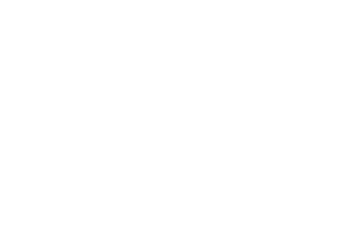

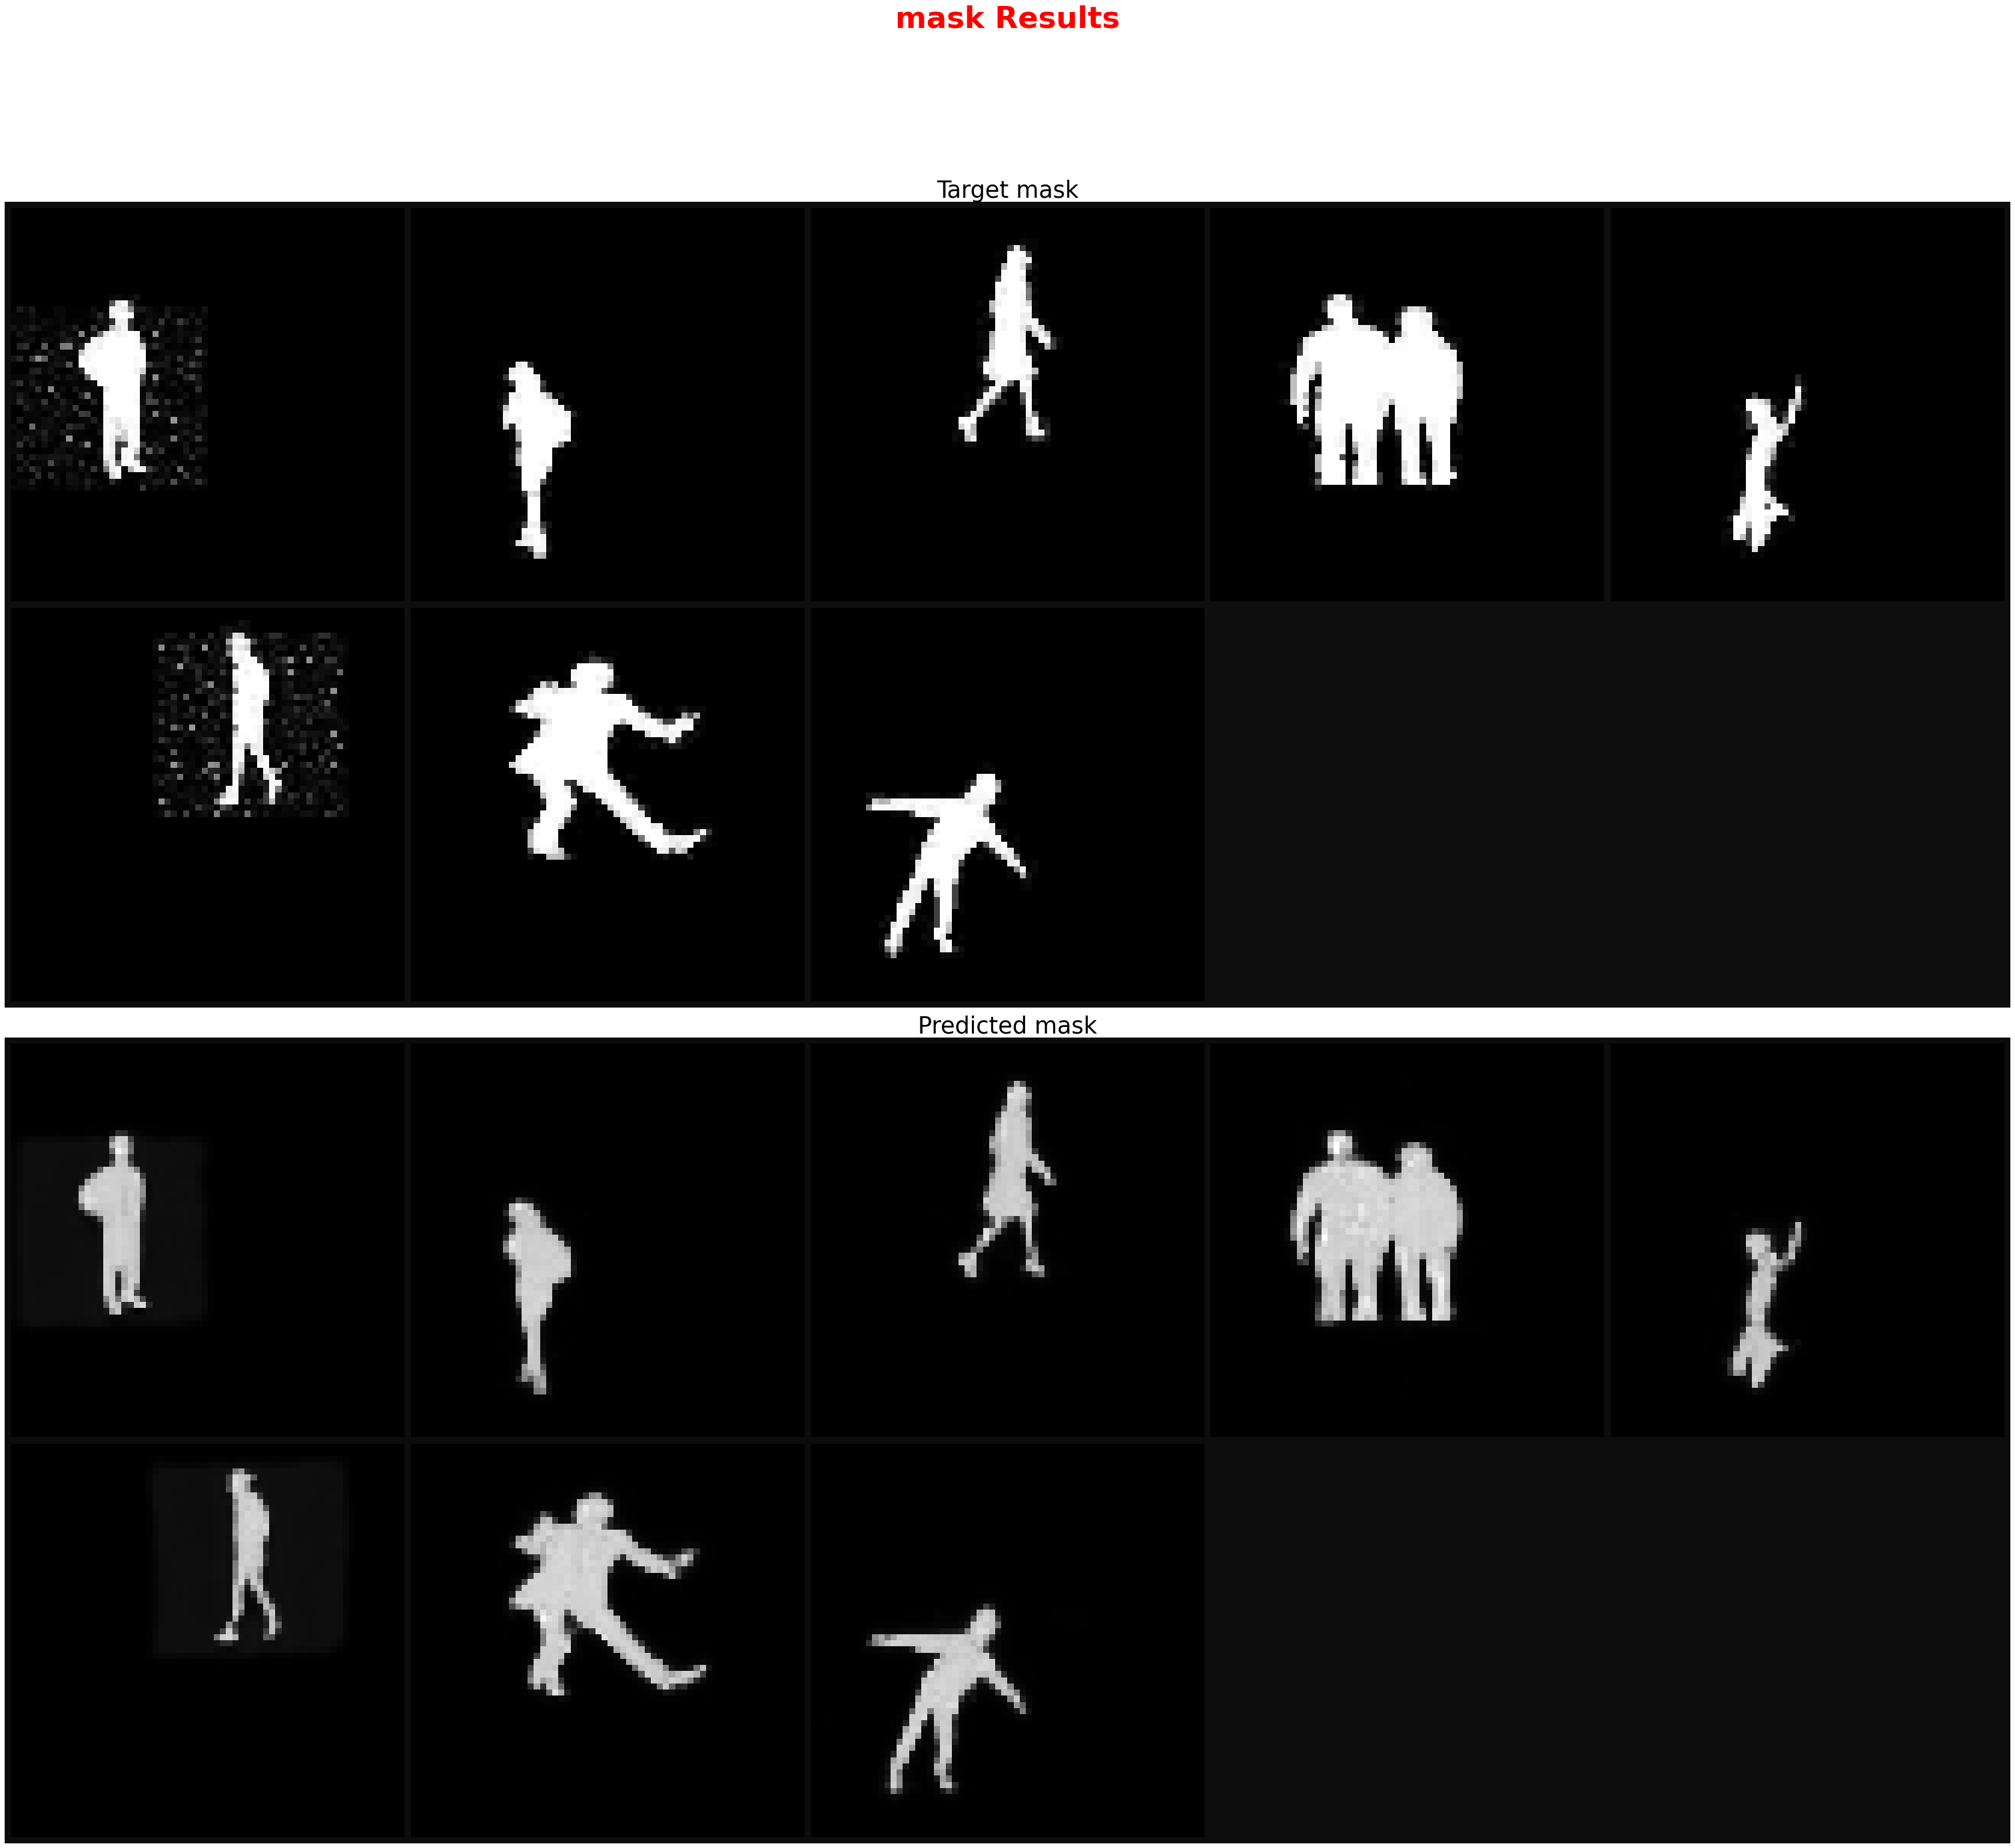

Results are saved in Results_ type.jpg


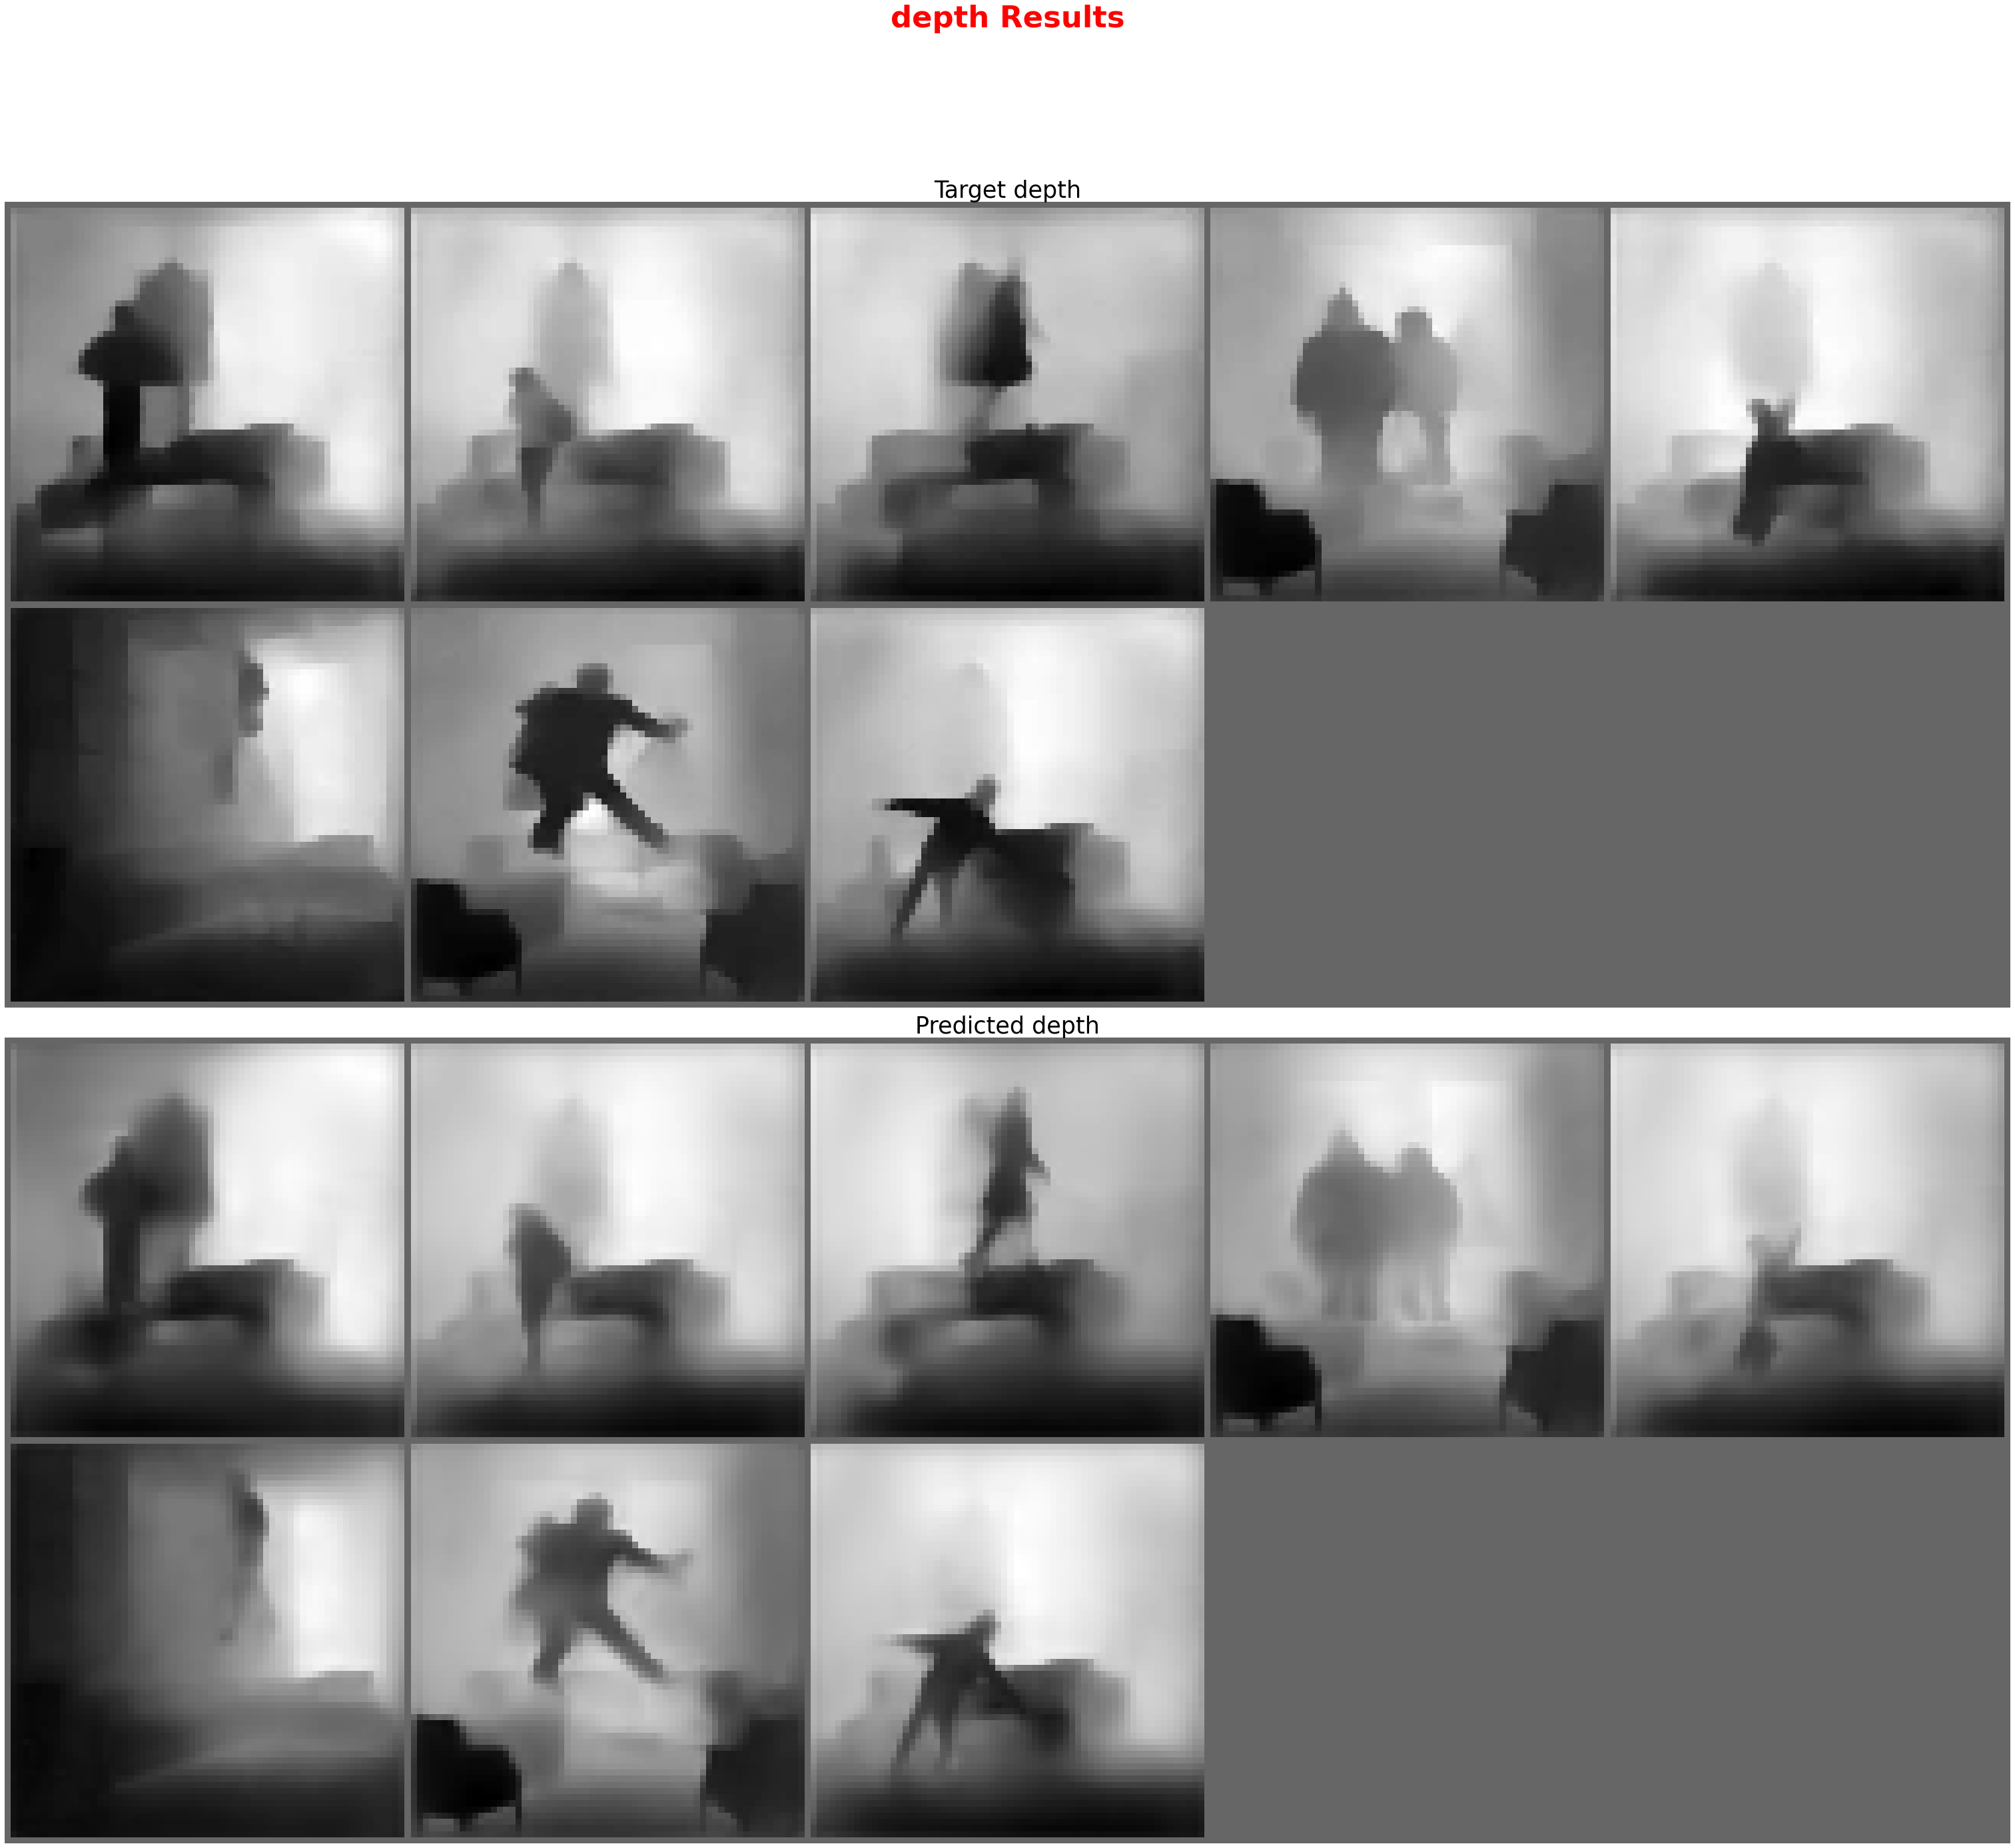

Results are saved in Results_ type.jpg


In [ ]:
show_results(model,test_loader,name = "Results")